<h1>Capstone Project: Classification</h1>

<h3>Preprocessing</h3>

In [1]:
#Seed my N-number
n_num = 16154377
import random
random.seed(n_num)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

#Open the file
df = pd.read_csv('musicData.csv')

df_filtered = df.copy()
df_filtered = df_filtered.dropna()

#Convert any ? to NaNs
df_filtered.replace('?', np.nan, inplace=True)

#Encode the target variable Genre
le = LabelEncoder()
df_filtered['genre_encoded'] = le.fit_transform(df_filtered['music_genre'])
n_classes = len(le.classes_)
print(f"Number of Genres: {n_classes}")

#Stratified train-test split for each genre
test_index = []
for genre in df_filtered['music_genre'].unique():
    idx = df_filtered[df_filtered['music_genre'] == genre].sample(n=500, random_state=n_num).index
    test_index.extend(idx)

#Set the train and test datasets
test_df = df_filtered.loc[test_index]
train_df = df_filtered.drop(test_index)

#Set X and y train and test data, excluding information about artist/track
X_train = train_df.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre', 'genre_encoded'])
y_train = train_df['genre_encoded']
X_test = test_df.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre', 'genre_encoded'])
y_test = test_df['genre_encoded']

#Some variables are categorical, some are numerical
categorical_variables = ['key', 'mode']
numeric_variables = [col for col in X_train.columns if col not in categorical_variables]

#Preprocessing using Pipeline/ColumnTransformer for more simplified process
#SimpleImputer to compute missing values with strategies
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#Preprocessor for numerical and categorical data
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_variables),
    ('cat', categorical_pipeline, categorical_variables)
])

#PCA for dimensionality reduction
pca = PCA(n_components=0.95, random_state=n_num)

#Binarize y_test for multi-class AUC (shows correct/incorrect genres as 0-1)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

Number of Genres: 10


<h3>Random Forest Model</h3>

In [2]:
#Run 3 models to compare them all: Random Forest, Decision Tree, and AdaBoost
#Model 1: Random Forest
#Build a Random Forest model using Pipeline for preprocessing, PCA, and the model
random_forest = Pipeline([
    ('rf_preprocessing', preprocessor),
    ('rf_pca', pca),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=n_num))
])

#Fit on training set
random_forest.fit(X_train, y_train)

#Predict probabilities on test set
rf_y_pred_prob = random_forest.predict_proba(X_test)

#Compute AUC score
rf_auc = roc_auc_score(y_test_bin, rf_y_pred_prob)
print(f"Random Forest AUC Score: {rf_auc:.3f}")

Random Forest AUC Score: 0.897


<h3>Decision Tree Model</h3>

In [3]:
#Model 2: Decision Tree
#Build a Decision Tree model using Pipeline for preprocessing, PCA, and the model
decision_tree = Pipeline([
    ('dt_preprocessing', preprocessor),
    ('dt_pca', pca),
    ('dt', DecisionTreeClassifier(random_state=n_num))
])

#Fit on training set
decision_tree.fit(X_train, y_train)

#Predict probabilities on test set
dt_y_pred_prob = decision_tree.predict_proba(X_test)

#Compute AUC score
dt_auc = roc_auc_score(y_test_bin, dt_y_pred_prob)
print(f"Decision Tree AUC Score: {dt_auc:.3f}")

Decision Tree AUC Score: 0.658


<h3>AdaBoost Model</h3>

In [4]:
#Model 3: AdaBoost
#Build an AdaBoost model using Pipeline for preprocessing, PCA, and the model
adaboost = Pipeline([
    ('adaboost_preprocessing', preprocessor),
    ('adaboost_pca', pca),
    ('adaboost_model', AdaBoostClassifier(random_state=n_num))
])

#Fit on training set
adaboost.fit(X_train, y_train)

#Predict probabilities on test set
adaboost_y_pred_prob = adaboost.predict_proba(X_test)

#Compute AUC score
adaboost_auc = roc_auc_score(y_test_bin, adaboost_y_pred_prob)
print(f"Decision Tree AUC Score: {adaboost_auc:.3f}")

Decision Tree AUC Score: 0.824


<h3>AUROC Figure</h3>

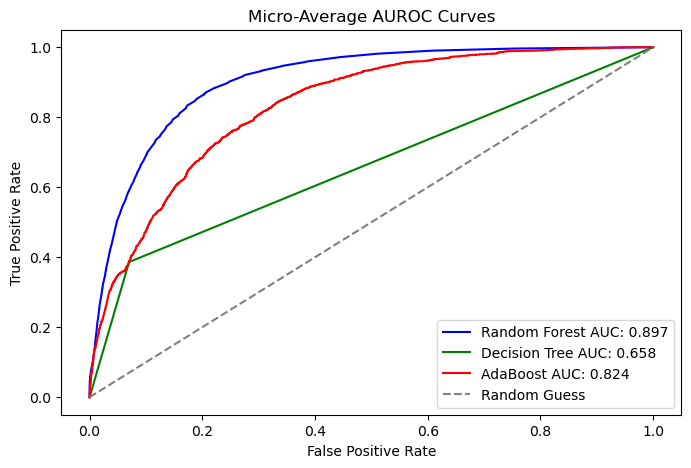

In [5]:
#Plot all AUROC Curves
plt.figure(figsize=(8, 5))

#Flatten all values for micro-average
y_flatten = y_test_bin.ravel()
rf_scores = rf_y_pred_prob.ravel()
dt_scores = dt_y_pred_prob.ravel()
ab_scores = adaboost_y_pred_prob.ravel()

#Plot Random Forest Curve
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_flatten, rf_scores)
plt.plot(rf_fpr, rf_tpr, color='blue', label=f'Random Forest AUC: {rf_auc:.3f}')

#Plot Decision Tree Curve
dt_fpr, dt_tpr, dt_threshold = roc_curve(y_flatten, dt_scores)
plt.plot(dt_fpr, dt_tpr, color='green', label=f'Decision Tree AUC: {dt_auc:.3f}')

#Plot AdaBoost Curve
ab_fpr, ab_tpr, ab_threshold = roc_curve(y_flatten, ab_scores)
plt.plot(ab_fpr, ab_tpr, color='red', label=f'AdaBoost AUC: {adaboost_auc:.3f}')

#Plot Random Guess
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

#Finish plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Average AUROC Curves")
plt.legend()
plt.show()

<h3>2D PCA Clustering</h3>

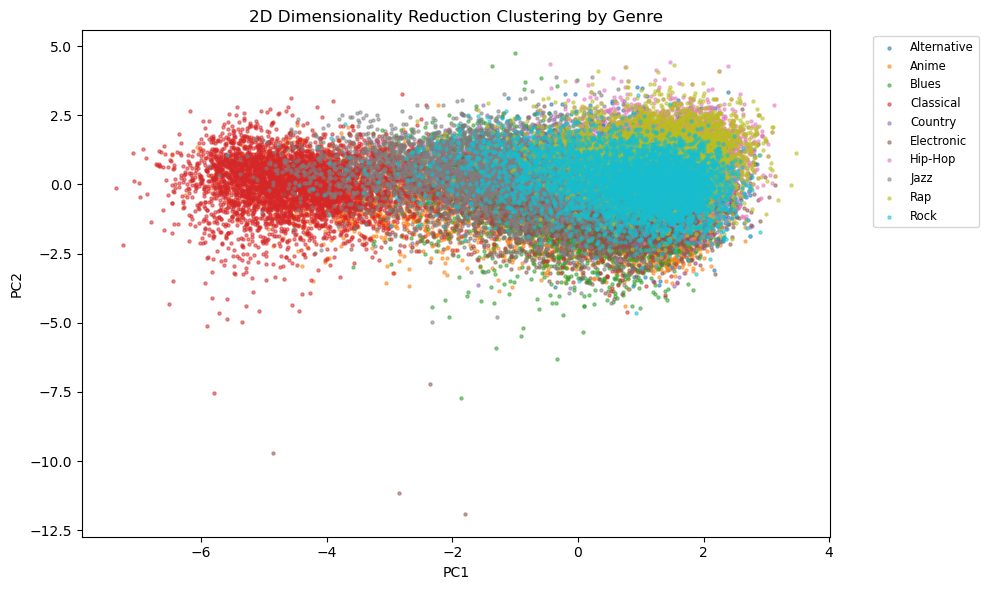

In [6]:
#Set X and y variables from df_filtered full dataset
X = df_filtered.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre', 'genre_encoded'])
y = df_filtered['music_genre']

#Perform PCA on full dataset (use preprocessor from beginning)
X_process = preprocessor.fit_transform(X)
X_pca = PCA(n_components=2, random_state=n_num).fit_transform(X_process)

#Encode the target variable Genre
le_all = LabelEncoder()
labels_all = le_all.fit_transform(y)
classes_all = le_all.classes_

#Create 2D PCA Figure
plt.figure(figsize=(10, 6))
for i, genre in enumerate(classes_all):
    idx = labels_all == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=genre, alpha=0.5, s=5)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Dimensionality Reduction Clustering by Genre')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

<h3>Extra Credit</h3>

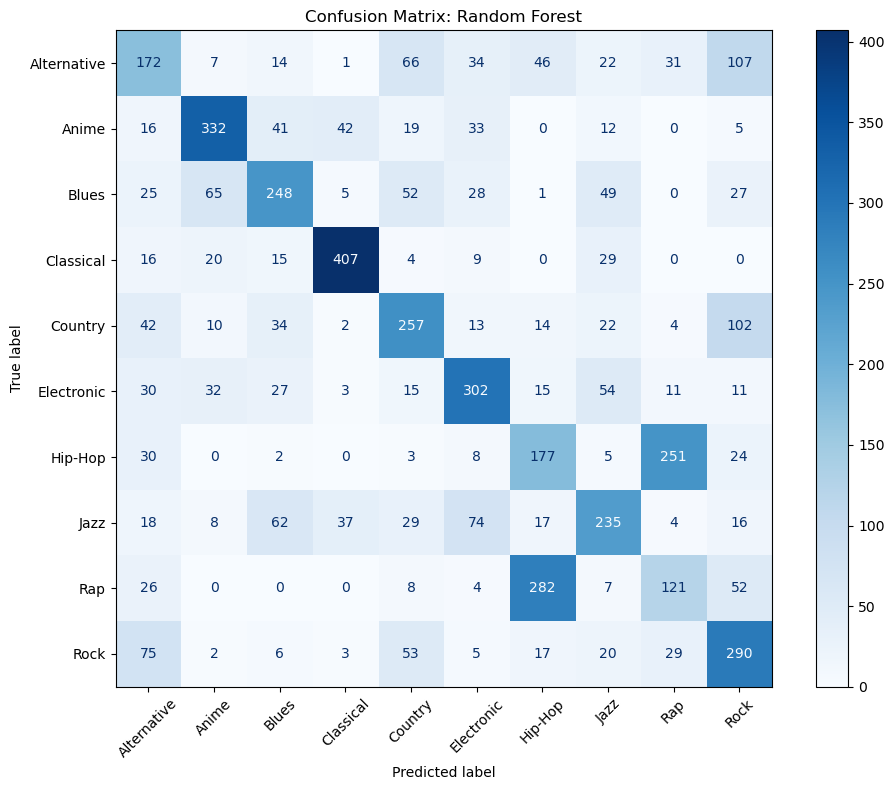

In [7]:
#Confusion Matrix for the best model: Random Forest
#Predict genres for the Random Forest model
rf_y_pred = random_forest.predict(X_test)

#Compute Confusion Matrix
cm = confusion_matrix(y_test, rf_y_pred)

#Display the Confusion Matrix
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix: Random Forest')
plt.tight_layout()
plt.show()